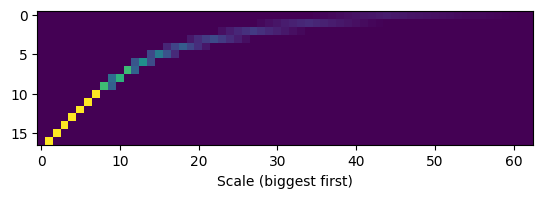

In [10]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.fftpack import dct, idct
import glob
import os
import subprocess
from random import sample

SAMPLE_RATE = 24000
WAVELET_NAME = "mexh"
WAVELET_SCALES = np.arange(0.5, 32, 0.5)
EXAMPLES_PER_BATCH = 32
SAMPLES_PER_EXAMPLE = SAMPLE_RATE * 4
NUM_WAVES = 3
NUM_OTHER_FEATURES = 11
NUM_MELS = 32
NUM_DCT_COEFFICIENTS = 10
SYNTHESIZER_PATH = "C:\\Users\\abdulg\\source\\repos\\Synth\\out\\build\\x64-debug\\synth.exe"
epsilon = np.finfo(np.float64).smallest_normal

def getMelFilterBank():
	freqs = np.asarray(
		[pywt.scale2frequency(WAVELET_NAME, scale) * SAMPLE_RATE for scale in WAVELET_SCALES] 
	)

	def freq2Mel(freq):
		return 1125 * np.log(1 + freq / 700)

	def mel2Freq(mel):
		return 700 * (np.exp(mel/1125) - 1)

	lowestMel = freq2Mel(freqs[-1])
	highestMel = freq2Mel(freqs[0])
	mels = np.linspace(lowestMel, highestMel, NUM_MELS + 2)
	freqPoints = np.asarray([mel2Freq(mel) for mel in mels])

	differences = np.abs(freqPoints[:, np.newaxis] - freqs)
	minima = np.argmin(differences, axis=1)
	minima = np.flip(np.unique(minima))
	freqPoints = freqs[minima]

	def melFilterRow(melNumber):
		row = np.zeros(len(WAVELET_SCALES))
		for i in range(len(WAVELET_SCALES)):
			currentScaleFreq = freqs[i]
			if currentScaleFreq >= freqPoints[melNumber]:
				if currentScaleFreq <= freqPoints[melNumber + 1]:
					row[i] = (currentScaleFreq - freqPoints[melNumber])/(freqPoints[melNumber + 1] - freqPoints[melNumber])
				elif currentScaleFreq <= freqPoints[melNumber + 2]:
					row[i] = (freqPoints[melNumber + 2] - currentScaleFreq )/(freqPoints[melNumber + 2] - freqPoints[melNumber + 1])
			else:
				break
		return row

	fbank = np.asarray([melFilterRow(i) for i in range(len(freqPoints) - 2)])
	return fbank / np.sum(fbank, axis=1, keepdims=1)

fbank = getMelFilterBank()
plt.imshow(fbank, origin="upper")
plt.xlabel("Scale (biggest first)")
plt.show()

In [ ]:
def getScaleograms(waveFiles):
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	return np.asarray([np.abs(pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0]) for wave in waves])

def getMLSs(waveFiles):
	scaleograms = getScaleograms(waveFiles)
	melScaleograms = [np.matmul(fbank, scaleo)**2 for scaleo in scaleograms]
	return np.asarray(melScaleograms) #[librosa.power_to_db(melScaleo) for melScaleo in melScaleograms])

datapath = os.path.abspath("./validationdata")
randomSample = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
print(randomSample)
scaleo = getScaleograms(randomSample)[0]

fig, axes = plt.subplots(2,3)

axes[0][0].imshow(scaleo, cmap="viridis", aspect="auto", origin="lower")
axes[0][0].set_title("scaleogram")
axes[0][0].axis("off")

logs = np.log(scaleo + 1)
axes[0][1].imshow(logs, cmap="viridis", aspect="auto", origin="lower")
axes[0][1].set_title("log scaleogram")
axes[0][1].axis("off")

axes[0][2].imshow(dct(logs, axis=1, type=2, norm="ortho")[:, :50], cmap="viridis", aspect="auto", origin="lower")
axes[0][2].set_title("DCT log scaleogram")
axes[0][2].axis("off")

energies = np.matmul(fbank,scaleo)**2
axes[1][0].imshow(energies, cmap="viridis", aspect="auto", origin="lower")
axes[1][0].set_title("melscaleogram")
axes[1][0].axis("off")

lms = np.log(np.matmul(fbank,scaleo)**2 + 1)
axes[1][1].imshow(lms, cmap="viridis", aspect="auto", origin="lower")
axes[1][1].set_title("log-melscaleogram")
axes[1][1].axis("off")

mfcc = dct(lms, axis=1, norm="ortho")[:,:50]
axes[1][2].imshow(mfcc, cmap="viridis", aspect="auto", origin="lower")
axes[1][2].set_title("MFCCs")
axes[1][2].axis("off")

plt.show()

In [ ]:
def getScaleograms(waveFiles):
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	return np.asarray([np.abs(pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0]) for wave in waves])

def getMLSs(waveFiles):
	scaleograms = getScaleograms(waveFiles)
	melScaleograms = [np.matmul(fbank, scaleo)**2 for scaleo in scaleograms]
	return np.asarray(melScaleograms) #[librosa.power_to_db(melScaleo) for melScaleo in melScaleograms])


datapath = os.path.abspath("./validationdata")
randomSample = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
scaleo = getScaleograms(randomSample)[0]

fig, axes = plt.subplots(3)

mul = np.matmul(fbank,scaleo)**2 
lms = np.log(mul + epsilon)
axes[0].imshow(lms, cmap="viridis", aspect="auto", origin="lower")
axes[0].set_title("eps")
axes[0].axis("off")

lms = np.log(mul + np.min(mul[np.nonzero(mul)]))
axes[1].imshow(lms, cmap="viridis", aspect="auto", origin="lower")
axes[1].set_title("smol")
axes[1].axis("off")


lms = np.log(mul + 0.1)
axes[2].imshow(lms, cmap="viridis", aspect="auto", origin="lower")
axes[2].set_title("1")
axes[2].axis("off")


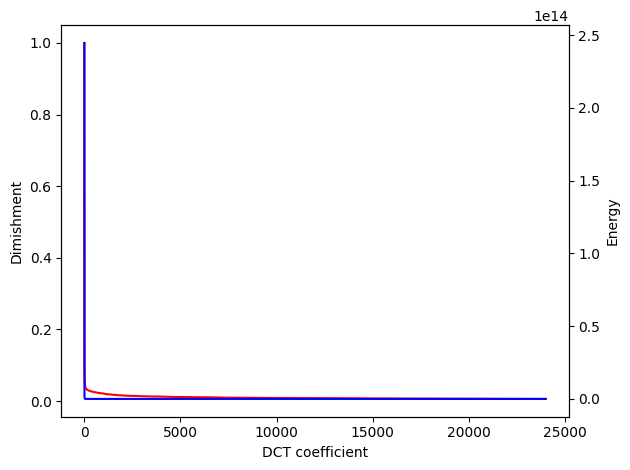

In [ ]:
def loadMFCCs():
	datapath = os.path.abspath("./validationdata")
	waveFiles = glob.glob(os.path.join(datapath, "*.wav"))
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	wavesWithEnergy = [w for w in waves if np.max(w) > 0]
	scaleograms = [np.abs(pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0]) for wave in wavesWithEnergy]
	melScaleograms = np.asarray([np.matmul(fbank, scaleo) for scaleo in scaleograms])
	minNonzero = np.min(melScaleograms[np.nonzero(melScaleograms)])
	melLogScaleograms = [np.log(melScaleo + minNonzero / 2) for melScaleo in melScaleograms]
	return np.asarray([dct(scaleo, type=2, axis=1, norm="ortho") for scaleo in melLogScaleograms])

mfccs = loadMFCCs()
numcandidates = SAMPLE_RATE
energiesPCPE = np.sum(mfccs ** 2, axis=1)
originalEnergies = np.sum(energiesPCPE, axis=1)
cumulativeNormalisedEPCPE = energiesPCPE.cumsum(axis=1) / originalEnergies[:, np.newaxis]

def getAverageEnergyDiminishment(numCoeffs):
	return 1 - np.sum(cumulativeNormalisedEPCPE[:, numCoeffs]) / len(mfccs)

diminishment = [1] + [getAverageEnergyDiminishment(c) for c in range(numcandidates - 1)]
averageEPC = np.mean(energiesPCPE, axis=0)[:numcandidates - 1]

fig, ax1 = plt.subplots()
ax1.set_xlabel("DCT coefficient")
ax1.set_ylabel("Dimishment")
ax1.plot(range(numcandidates), diminishment, color="red", label="Diminshment")

ax2 = ax1.twinx()
ax2.set_ylabel("Energy")
ax2.plot(range(1, numcandidates),averageEPC[:numcandidates - 1], color="blue", label="Energy")

fig.tight_layout()
#plt.show()

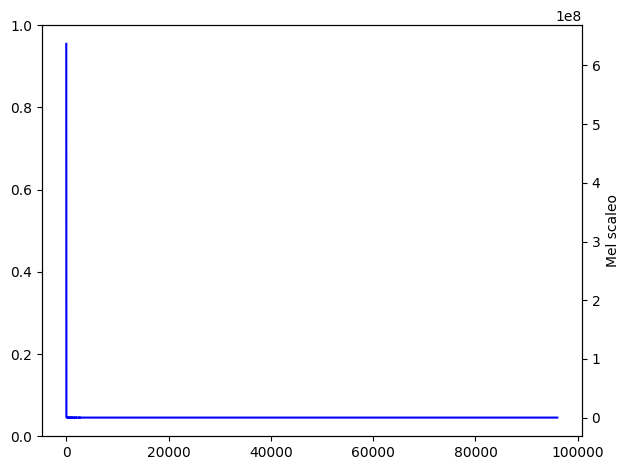

In [12]:
datapath = os.path.abspath("./validationdata")
waveFiles = glob.glob(os.path.join(datapath, "*.wav"))
waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
wavesWithEnergy = [w for w in waves if np.max(w) > 0]
scaleograms = np.asarray([np.abs(pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0]) for wave in wavesWithEnergy])

#scaleogramEnergiesPC = np.mean(np.sum(scaleograms ** 2, axis=1), axis=0)
melScaleograms = np.asarray([np.matmul(fbank, scaleo) for scaleo in scaleograms])
minNonzero = np.min(melScaleograms[np.nonzero(melScaleograms)])
melLogScaleograms = [np.log(melScaleo + minNonzero/2) for melScaleo in melScaleograms]
melDCT = np.asarray([dct(scaleo, type=2, axis=1, norm="ortho") for scaleo in melLogScaleograms])
melScaleogramEnergyPC = np.mean(np.sum(melDCT**2, axis=1), axis=0)

fig, ax1 = plt.subplots()
#ax1.set_xlabel("DCT coefficient")
#ax1.set_ylabel("Scaleo")
#ax1.plot(range(len(scaleogramEnergiesPC)), scaleogramEnergiesPC, color="red", label="Scaleo")

ax2 = ax1.twinx()
ax2.set_ylabel("Mel scaleo")
ax2.plot(range(len(melScaleogramEnergyPC)), melScaleogramEnergyPC, color="blue", label="Mel Scaleo")

fig.tight_layout()